In [76]:
# Basic data processing packages
import os
import glob
import numpy as np
from matplotlib import pyplot as plt, image as mpimg
%matplotlib inline

# Advanced Machine Learning Packages 
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint
# Testing Packages
from sklearn.metrics import confusion_matrix, roc_curve, auc
import livelossplot

In [77]:
# Move a part of image dataset
def move_data(src_path, dest_path, size):
    vehicle_images = glob.glob(src_path + '/vehicles/*')
    non_vehicle_images = glob.glob(src_path + '/non-vehicles/*')
    
    # Move only if the source data size if larger than the intended size
    if len(vehicle_images) >= size:
        for i in range(0, size):
            fname = vehicle_images[i]
            os.rename(fname, os.path.join(dest_path, 'vehicles', os.path.basename(fname)))

            fname = non_vehicle_images[i]
            os.rename(fname, os.path.join(dest_path, 'non-vehicles', os.path.basename(fname)))

            if i % (size / 5) == 0:
                print(i + (size // 5), ' images moved.')
        print(size, 'total images moved.')

In [78]:
# Load images
def load_data(data_path, train_size, validation_size):
    # Split image dataset into train and validation
    for dir in ['train', 'validation']:
        for sub_dir in ['vehicles', 'non-vehicles']:
            path = os.path.join(os.getcwd(), data_path, dir)
            if not os.path.exists(path):
                os.mkdir(path)
            path = os.path.join(path, sub_dir)
            if not os.path.exists(path):
                os.mkdir(path)

    # Move a number of images in each category into train directory
    train_data_size = len(glob.glob(data_path + '/train/vehicles/*'))
    # Move only if train directory is empty
    if train_data_size == 0 :    
        move_data(data_path + '/raw', data_path + '/train', train_size)
        
    # Move a number of images in each category into validation directory
    validation_data_size = len(glob.glob(data_path + '/validation/vehicles/*'))
    # Move only if validation directory is empty
    if validation_data_size == 0 :    
        move_data(data_path + '/raw', data_path + '/validation', validation_size)
        

In [79]:
# Visualize samples
def visualize_data(path):
    vehicle_images = glob.glob(path + '/vehicles/*')
    non_vehicle_images = glob.glob(path + '/non-vehicles/*')
    
    fig, axes = plt.subplots(2, 2, figsize = (4, 4))
    i = 0
    for j in np.random.randint(0, 100, 2):
        
        vehicle_image = mpimg.imread(vehicle_images[j])
        axes[i, 0].set_title('Sample Vehicle Image ' + str(i+1))
        axes[i, 0].imshow(vehicle_image)

        non_vehicle_image = mpimg.imread(non_vehicle_images[j])
        axes[i, 1].set_title('Sample Non-Vehicle Image ' + str(i+1))
        axes[i, 1].imshow(non_vehicle_image)
        i += 1

In [80]:
#(Use Haseeb's Existing Libraries if you want) Ot Augment data with additional Data Generation.
#So you can actively comment this whole section out.
def augment_data(target_size, batch_size = 16):
    # Augmentation config for training data set
    train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True)
    
    #Generate batches of augmented train image data
    train_generator = train_datagen.flow_from_directory(
                    'data/train',
                    target_size = target_size,
                    batch_size = batch_size,
                    class_mode = 'binary')
    
    # Augmentation config for validation set
    # Data scaling.
    validation_datagen = ImageDataGenerator(rescale = 1./255)
    validation_generator = validation_datagen.flow_from_directory(
                        'data/validation',
                        target_size = target_size,
                        batch_size = batch_size,
                        class_mode = 'binary')
    
    return train_generator, validation_generator

In [159]:
# Build Convolutional Neural Net Model 
def build_model(input_size = (150, 150, 3)):
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = 3,
                     activation = 'relu', input_shape = input_size))
    model.add(MaxPooling2D(pool_size = 2))
    
    model.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))
    
    model.add(Conv2D(filters = 64, kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))
    
    # this converts our 3D feature maps to 1D feature vectors
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop', metrics=['accuracy'])
    return model

In [89]:
# Fit model
def fit_model(model, train_generator, validation_generator, callbacks, epochs = 50, batch_size = 16):
    model.fit_generator(train_generator,
                        steps_per_epoch = 5000 // batch_size,
                        epochs = epochs,
                        validation_data = validation_generator,
                        validation_steps = 1000 // batch_size,
                        callbacks = callbacks)
    return model

In [90]:
# Start
load_data(data_path = 'data', train_size = 4000, validation_size = 1000)

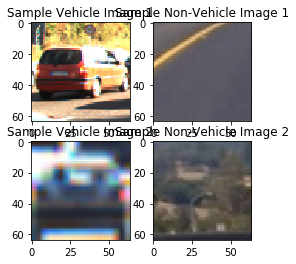

In [139]:
visualize_data(path = 'data/train')

In [140]:
train_gen, validation_gen = augment_data(target_size = (64, 64), batch_size = 16)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [141]:
model = build_model((64, 64, 3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2304)              0         
__________

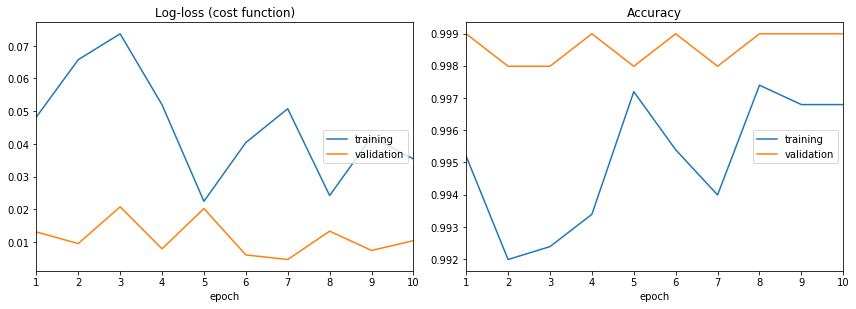


Epoch 00010: saving model to checkpoints/weights.hdf5


In [158]:
# Save the weights at each epoch
check = ModelCheckpoint(filepath = 'checkpoints/weights.hdf5', verbose = 1)

# Plot live losses
plot_losses = livelossplot.PlotLossesKeras()

callbacks = [plot_losses, check]

fit_model(model, train_gen, validation_gen, callbacks, epochs = 10, batch_size = 16)
model.save_weights('first_try.h5')

In [160]:
model.load_weights('first_try.h5')

test_gen = ImageDataGenerator(rescale = 1./255).flow_from_directory(
                        'data/test',
                        target_size = (64, 64),
                        batch_size = 16,
                        class_mode = 'binary',
                        shuffle = False)

pred = model.predict_generator(test_gen)

Found 16 images belonging to 2 classes.


[[10  0]
 [ 0  6]]


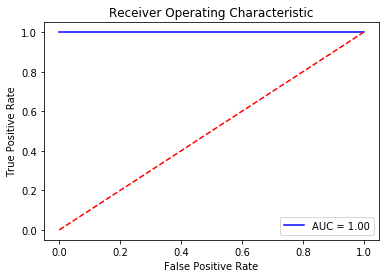

In [163]:
# ROC and AUC
label_map = test_gen.classes
# Get the false and true positive rates to be used for ROC
fpr, tpr, threshold = roc_curve(label_map, pred)
# Compute area under curve for the ROC
roc_auc = auc(fpr, tpr)

# Print confusion matrix
matrix = confusion_matrix(label_map, pred.round())
print(matrix)

 
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

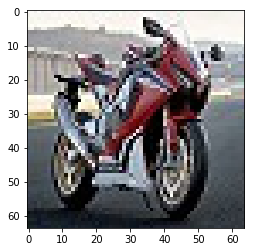

In [164]:
# Predicting an image
img = mpimg.imread('data/test/bike.jpg')
fig = plt.figure(figsize=(4, 4))
fig.add_subplot(1, 1, 1)
plt.imshow(img)

In [167]:
img_crop = np.expand_dims(img, axis = 0)
pr = model.predict(img_crop)
pr

array([[1.]], dtype=float32)

In [175]:
(['car'.encode('utf8')] * 2).iloc[2]

AttributeError: 'list' object has no attribute 'iloc'